In [323]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
import branca.colormap as cm

In [324]:
with open('../config.yaml') as file:
  params= yaml.safe_load(file)

preprocessed_data_folder = params['data_folder'] + "preprocessed/"

In [325]:
df_tracks_all = pd.read_pickle(preprocessed_data_folder + 'pp_merged_all.pkl')
df_robot_all = pd.read_pickle(preprocessed_data_folder + 'pp_robot_all.pkl')
df_orientations_all = pd.read_pickle(preprocessed_data_folder + 'pp_orientations_all.pkl')

In [326]:
df_orientations_all.columns

Index(['timestamp_begin', 'timestamp_end', 'obj.label_id_unique',
       'sample_count', 'robot_begin_longitude', 'robot_begin_latitude',
       'robot_end_longitude', 'robot_end_latitude', 'robot_corr_coeff',
       'robot_dir_vector', 'human_begin_longitude', 'human_begin_latitude',
       'human_end_longitude', 'human_end_latitude', 'human_corr_coeff',
       'human_dir_vector', 'human_speed_est', 'min_distance', 'robot_speed',
       'robot_rotation', 'HDOP', 'angle_robot_human',
       'obj.label_id_width_date', 'robot_crossing_dist_mean',
       'human_crossing_dist_mean', 'robot_crossing_dist_min',
       'human_crossing_dist_min', 'robot_crossing_dist_max',
       'human_crossing_dist_max', 'human_crossing_ratio',
       'robot_crossing_ratio', 'context', 'pedestrian_count', 'date',
       'human_duration', 'interaction_duration'],
      dtype='object')

In [327]:
speed_threshold = 0.4
coeff_threshold = 0.5

In [328]:
print(df_orientations_all.shape[0])
print(df_orientations_all[df_orientations_all['human_speed_est'] < speed_threshold].shape[0])
print(df_orientations_all[abs(df_orientations_all['human_corr_coeff']) < coeff_threshold].shape[0])

987
163
187


In [329]:
features = ['human_speed_est', 'angle_robot_human',
 'human_crossing_dist_min', 'robot_crossing_dist_min',
 'human_crossing_dist_max', 'robot_crossing_dist_max',
 'human_crossing_dist_mean', 'robot_crossing_dist_mean',
 'robot_speed', 'robot_rotation', ]

#features = ['human_speed_est', 'angle_robot_human',
# 'human_crossing_dist_min', 'robot_crossing_dist_min',
# 'human_crossing_dist_max', 'robot_crossing_dist_max',
# 'human_crossing_dist_mean', 'robot_crossing_dist_mean',
# 'robot_speed', 'robot_rotation', 'min_distance', 'pedestrian_count', 'interaction_duration']

#features = ['human_speed_est', 'angle_robot_human',
# 'human_crossing_dist_min', 'robot_crossing_dist_min',
# 'human_crossing_dist_max', 'robot_crossing_dist_max',
# 'human_crossing_dist_mean', 'robot_crossing_dist_mean',
# 'robot_speed', 'robot_rotation', 'robot_speed', 'min_distance', 'pedestrian_count']

In [330]:
df_orientations_all[features].describe().T

,count,mean,std,min,25%,50%,75%,max
human_speed_est,872.0,1.043219,1.115591,0.008555,0.497945,0.874040,1.267945,20.983152
angle_robot_human,973.0,1.674802,1.183008,0.000523,0.356513,1.920238,2.882305,3.141134
human_crossing_dist_min,987.0,12.166103,10.359799,0.038736,4.989237,8.894871,16.275949,65.874006
robot_crossing_dist_min,987.0,12.475479,10.539135,0.157978,4.709172,8.956311,17.216290,61.922279
human_crossing_dist_max,987.0,15.024814,10.754906,0.603094,7.365597,11.523135,20.583548,67.422964
robot_crossing_dist_max,987.0,15.182793,10.974755,0.902755,6.973938,11.905553,20.652965,62.112641
human_crossing_dist_mean,987.0,13.536281,10.458957,0.489791,6.116042,10.153896,18.421584,66.726715
robot_crossing_dist_mean,987.0,13.767574,10.692047,0.772733,5.980607,10.341944,18.875899,61.994672
robot_speed,987.0,0.774348,0.230013,0.042386,0.630289,0.879895,0.946589,1.515120
robot_rotation,987.0,0.162989,0.341859,0.003316,0.043327,0.078094,0.164045,4.429718


In [331]:
print(df_orientations_all.shape[0])
df_orientations_all = df_orientations_all[abs(df_orientations_all['human_corr_coeff']) > coeff_threshold]
print(df_orientations_all.shape[0])

987
786


In [332]:
df_orientations_all['human_speed_est'] = df_orientations_all['human_speed_est'].apply( lambda x: x if x<=3 else np.nan )
df_orientations_all['robot_rotation'] = df_orientations_all['robot_rotation'].apply( lambda x: x if x<=0.5 else np.nan )
df_orientations_all.dropna(subset=features).shape

(654, 36)

In [333]:
cluster_count = 5

scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

normed_df = df_orientations_all.dropna(subset=features)

df = scaler.fit_transform(
    normed_df[features]
)

In [334]:
df.shape

(654, 10)

In [335]:
def create_importance_dataframe(pca, original_num_df):

    # Change pcs components ndarray to a dataframe
    importance_df  = pd.DataFrame(pca.components_)

    # Assign columns
    importance_df.columns  = original_num_df.columns

    # Change to absolute values
    importance_df =importance_df.apply(np.abs)

    # Transpose
    importance_df=importance_df.transpose()

    # Change column names again

    ## First get number of pcs
    num_pcs = importance_df.shape[1]

    ## Generate the new column names
    new_columns = [f'PC{i}' for i in range(1, num_pcs + 1)]

    ## Now rename
    importance_df.columns  =new_columns

    # Return importance df
    return importance_df

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

importance_df  =create_importance_dataframe(pca, df_orientations_all[features])
importance_df['PC1'].sort_values(ascending = False)

[0.57198788 0.15724027]
0.7292281540788299


robot_crossing_dist_mean    0.411059
human_crossing_dist_mean    0.410752
robot_crossing_dist_min     0.407720
human_crossing_dist_min     0.404933
human_crossing_dist_max     0.404759
robot_crossing_dist_max     0.404504
angle_robot_human           0.061286
robot_rotation              0.024891
human_speed_est             0.016667
robot_speed                 0.000896
Name: PC1, dtype: float64

In [336]:
principal_df = pd.DataFrame(data = principalComponents, columns = ['x', 'y'])

In [337]:
kmeans = KMeans(n_clusters=cluster_count).fit(principal_df)
centroids = kmeans.cluster_centers_
print(centroids)

[[-1.60568188 -0.51281876]
 [ 3.67614933 -0.23843715]
 [ 0.80578717 -0.52753991]
 [-0.99417887  1.94918901]
 [ 7.38100352  0.67966742]]


In [338]:
principal_df['min_dist'] = normed_df['min_distance'] <= 1.5
principal_df['context'] = normed_df['context']
principal_df['angle_robot_human'] = normed_df['angle_robot_human']
principal_df['min_distance'] = normed_df['min_distance']
principal_df['robot_longitude'] = (normed_df['robot_begin_longitude'] + normed_df['robot_end_longitude'])/2
principal_df['robot_latitude'] = (normed_df['robot_begin_latitude'] + normed_df['robot_end_latitude'])/2
principal_df['robot_crossing_dist_min'] = normed_df['robot_crossing_dist_min']
principal_df['human_crossing_dist_min'] = normed_df['human_crossing_dist_min']

principal_df['cluster'] = kmeans.labels_.astype(float)
principal_df.head(3)

,x,y,min_dist,context,angle_robot_human,min_distance,robot_longitude,robot_latitude,robot_crossing_dist_min,human_crossing_dist_min,cluster
0,-0.764759,-1.332509,True,non-junction,3.074342,1.099307,13.342266,50.918415,5.469965,10.134625,0.0
1,1.281264,-1.299264,False,non-junction,2.958132,1.683914,13.342343,50.918348,12.863550,20.753480,2.0
2,1.222955,-1.328806,False,non-junction,2.975162,2.543111,13.342339,50.918351,13.124567,20.288601,2.0


In [339]:
principal_df

,x,y,min_dist,context,angle_robot_human,min_distance,robot_longitude,robot_latitude,robot_crossing_dist_min,human_crossing_dist_min,cluster
0,-0.764759,-1.332509,True,non-junction,3.074342,1.099307,13.342266,50.918415,5.469965,10.134625,0.0
1,1.281264,-1.299264,False,non-junction,2.958132,1.683914,13.342343,50.918348,12.863550,20.753480,2.0
2,1.222955,-1.328806,False,non-junction,2.975162,2.543111,13.342339,50.918351,13.124567,20.288601,2.0
3,6.511364,-0.727445,False,non-junction,3.086898,4.922141,13.342569,50.918161,39.566069,40.747851,4.0
4,6.553246,-1.481227,False,non-junction,3.100845,5.961498,13.342590,50.918145,43.047557,38.760757,4.0
...,...,...,...,...,...,...,...,...,...,...,...
649,-2.361250,0.088729,False,non-junction,3.030603,5.817664,13.342686,50.917685,12.938614,11.124518,0.0
650,-0.925057,1.307944,False,non-junction,2.919698,4.191089,13.342686,50.917685,13.957646,12.542361,3.0
651,6.549057,-0.558558,False,non-junction,0.476733,5.514490,13.342638,50.917667,7.690056,9.833543,4.0
652,4.640011,3.231817,False,uncertain,0.124476,2.493659,13.342607,50.917656,7.353560,4.109065,1.0


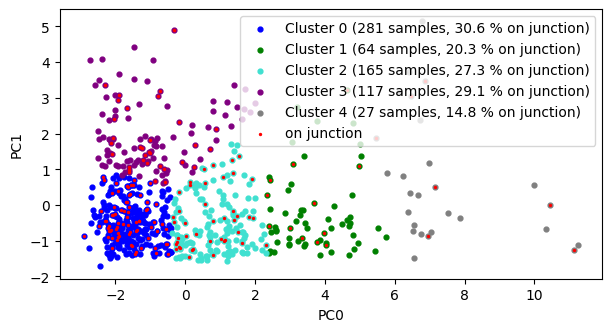

In [340]:
fig, ax = plt.subplots(figsize=(7,3.5))

color = ['blue', 'green', 'turquoise', 'purple', 'gray']

for i in principal_df['cluster'].sort_values().unique():
    count = principal_df[principal_df.cluster==i]
    on_junction = count[count.context=='junction'].shape[0] / count.shape[0] * 100
    principal_df.query('cluster == @i').plot.scatter(x='x', y='y', c=color[int(i)], ax=ax, s=12, 
                                                     label=f'Cluster {int(i)} ({count.shape[0]} samples, {on_junction:.1f} % on junction)')


principal_df.query('robot_crossing_dist_min <= 8 & human_crossing_dist_min < 8').plot.scatter(x='x', y='y', c='red', ax=ax, s=2, label="on junction")
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
plt.legend()

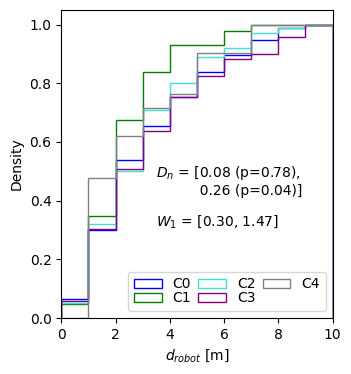

In [341]:
from scipy import stats

bins = list(np.arange(0, 10.5, 1))

fig, ax = plt.subplots(figsize=(3.5,4.0))

hist_list=[]

for cluster in principal_df.sort_values('cluster').cluster.unique():
    aux = principal_df[principal_df.cluster == cluster]
    aux.plot.hist(y='min_distance', cumulative=True, 
                  color=color[int(cluster)],
                  bins=bins, histtype='step', density=True,
                  label=f"C{int(cluster)}",# ({aux.shape[0]} samples)", alpha=1,
                  ax=ax)
    hist_list.append(aux['min_distance'])

min_ks_dist = [100, 0]
max_ks_dist = [0, 0]
min_ws_dist = 100
max_ws_dist = 0

for i in range(len(hist_list)):
    for j in range(len(hist_list)):
        samples_1 = hist_list[i]
        samples_2 = hist_list[j]
        ks = stats.ks_2samp(samples_1.dropna(), samples_2.dropna(), alternative='two-sided')
        ws = stats.wasserstein_distance(samples_1.dropna(), samples_2.dropna())
        if i != j:
            if ks.statistic > max_ks_dist[0]:
                max_ks_dist = [ks.statistic, ks.pvalue]
            if ks.statistic < min_ks_dist[0]:
                min_ks_dist = [ks.statistic, ks.pvalue]
            if ws > max_ws_dist:
                max_ws_dist = ws
            if ws < min_ws_dist:
                min_ws_dist = ws

#plt.rcParams.update({'font.size': 5})
ax.text(0.35, 0.4, f"$D_n$ = [{min_ks_dist[0]:.2f} (p={min_ks_dist[1]:.2f}),\n          {max_ks_dist[0]:.2f} (p={max_ks_dist[1]:.2f})]", transform=ax.transAxes)
ax.text(0.35, 0.3, f"$W_1$ = [{min_ws_dist:.2f}, {max_ws_dist:.2f}]", transform=ax.transAxes)

ax.set_xlim(0, 10);
ax.set_xlabel('$d_{robot}$ [m]');
ax.set_ylabel('Density');
ax.legend(loc="lower right",ncol=3, labelspacing = 0.01, columnspacing=0.5)

In [342]:
center = [principal_df['robot_latitude'].mean(), principal_df['robot_longitude'].mean()]

linear =  cm.LinearColormap(["red", "yellow", "green", "blue"], vmin=0, vmax=4)

mymap = folium.Map(location=center, zoom_start=18, max_zoom=20, attr='osm.com')

# Marker für jede Zeile in GNSS-Daten hinzufügen
for index, row in principal_df.dropna().iterrows():

    if row['cluster'] == 0 or row['cluster'] == 2:
        folium.Circle([row['robot_latitude'], row['robot_longitude']],
                    fill=True,
                            radius=3,
                            color=linear(row['cluster']),
                            fill_color=linear(row['cluster']),
                            fill_opacity=1.0,
                            #color = color
                            ).add_to(mymap)


# Karte anzeigen
mymap.save('map_.html')
mymap